In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils.data import get_hsm_dataset
from utils.visualization import visualization

In [2]:
dataset_dir = Path("data/huge_stock_market_dataset/")
results_dir = Path("results")

In [3]:
ts_info = pd.read_csv(dataset_dir / "selected.csv")
ts_info["ts_id"] = ts_info.index

c:\Users\Владислав\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


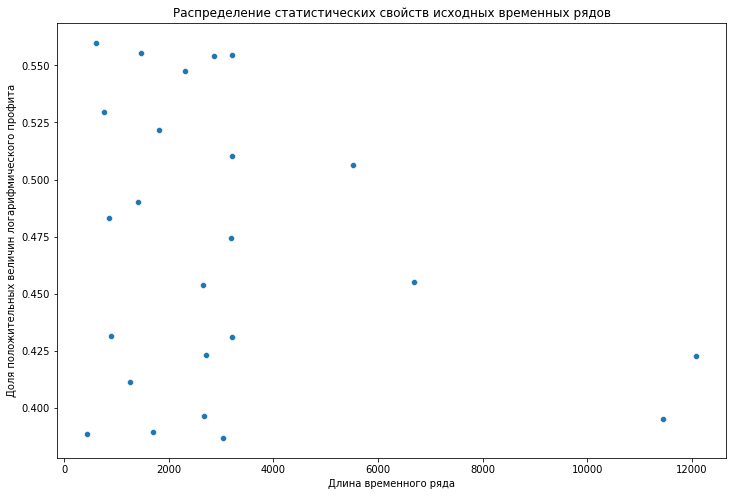

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(ts_info["length"], y=ts_info["uptrending_rate"], ax=ax)
ax.set_xlabel("Длина временного ряда")
ax.set_ylabel("Доля положительных величин логарифмического профита")
ax.set_title("Распределение статистических свойств исходных временных рядов")
plt.show()

In [5]:
horizon = 8
results = []
for results_type in ("pure", "QuantGAN_synth", "FourierFlow_synth", "RealNVP_synth", "TTS_GAN_synth"):
    for model in ("LSTM", "TCN", "cbr"):
        df = pd.read_csv(results_dir / f"{results_type}_{model}_h{horizon}.csv")
        df["model"] = model
        df["results_type"] = results_type
        results.append(df)
results = pd.concat(results)
results["model"].replace("cbr", "CatBoostRegressor", inplace=True)
results["results_type"].replace(["pure", "QuantGAN_synth", "FourierFlow_synth", "RealNVP_synth", "TTS_GAN_synth"],
                                ["train set", "QuantGAN synthetic data", "FourierFlow synthetic data", "RealNVP synthetic data", "TTS GAN synthetic data"], 
                                inplace=True)
results

,train,test,model,results_type
0,0.097664,0.618813,LSTM,train set
1,0.178904,0.888597,LSTM,train set
2,0.169664,0.793162,LSTM,train set
3,0.200256,0.758744,LSTM,train set
4,0.195375,0.637577,LSTM,train set
...,...,...,...,...
19,1.012060,0.683544,CatBoostRegressor,TTS GAN synthetic data
20,7.075217,3.598870,CatBoostRegressor,TTS GAN synthetic data
21,2.846970,2.290241,CatBoostRegressor,TTS GAN synthetic data
22,0.723327,0.678741,CatBoostRegressor,TTS GAN synthetic data


In [6]:
results_agg = results.groupby(by=["model", "results_type"], axis=0, as_index=False).agg(train=("train", "mean"), test=("test", "mean"))
results_agg

,model,results_type,train,test
0,CatBoostRegressor,FourierFlow synthetic data,0.542745,0.505860
1,CatBoostRegressor,QuantGAN synthetic data,0.656615,0.584780
2,CatBoostRegressor,RealNVP synthetic data,0.552762,0.541950
3,CatBoostRegressor,TTS GAN synthetic data,1.122955,0.889318
4,CatBoostRegressor,train set,0.588460,0.552846
5,LSTM,FourierFlow synthetic data,0.396985,0.552681
6,LSTM,QuantGAN synthetic data,0.657241,0.567972
7,LSTM,RealNVP synthetic data,0.241456,0.600452
8,LSTM,TTS GAN synthetic data,1.109321,0.864953
9,LSTM,train set,0.206365,0.672677


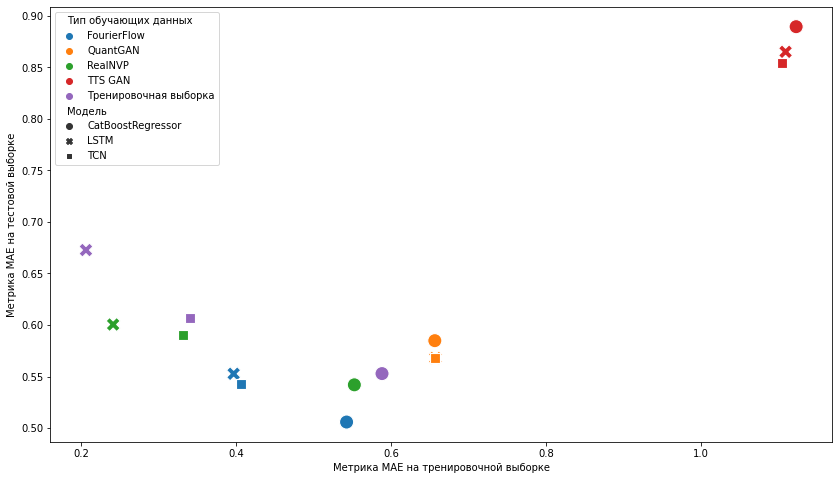

In [7]:
fig, ax = plt.subplots(1, figsize=(14, 8))
# sns.scatterplot(data=results_agg[results_agg.index.get_level_values(1) != "TTS GAN synthetic data"], x="train", y="test", hue="results_type", style="model", s=200, ax=ax)

temp = results_agg.rename(columns={"results_type": "Тип обучающих данных", "model": "Модель"}).\
    replace({"FourierFlow synthetic data": "FourierFlow", "QuantGAN synthetic data": "QuantGAN", "RealNVP synthetic data": "RealNVP",
        "TTS GAN synthetic data": "TTS GAN", "train set": "Тренировочная выборка"})
sns.scatterplot(data=temp, x="train", y="test", hue="Тип обучающих данных", style="Модель", s=200, ax=ax)
ax.set_xlabel("Метрика MAE на тренировочной выборке")
ax.set_ylabel("Метрика MAE на тестовой выборке")
plt.show()

<AxesSubplot:xlabel='model', ylabel='test'>

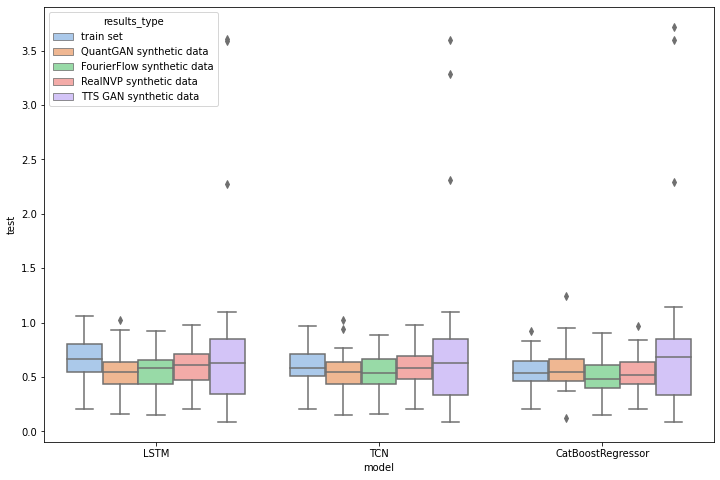

In [9]:
fig, ax = plt.subplots(1, figsize=(12, 8))
# sns.boxplot(data=results[results.results_type != "TTS GAN synthetic data"], x="model", y="test", hue="results_type", palette="pastel", ax=ax)
sns.boxplot(data=results, x="model", y="test", hue="results_type", palette="pastel", ax=ax)

# Gains

In [36]:
pure = results[results.results_type == "train set"]
gains = None
for synth_rt in (x for x in results.results_type.unique() if x != "train set"):
    synth_df = results[results.results_type == synth_rt]
    gain = (pure.groupby([pure.index, "model"]).mean() - synth_df.groupby([synth_df.index, "model"]).mean()) / pure.groupby([pure.index, "model"]).mean() * 100
    gain.index, gain["model"] = gain.index.get_level_values(0), gain.index.get_level_values(1)
    synth_rt = synth_rt.split(' ')[0]
    gain.rename(columns={"train": f"train_{synth_rt}", "test": f"test_{synth_rt}"}, inplace=True)
    gain["ts_id"] = gain.index
    if gains is None:
        gains = gain
    else:
        gains = gains.merge(gain, on=["model", "ts_id"])

gains = gains.merge(ts_info, on="ts_id")
gains

,train_QuantGAN,test_QuantGAN,model,ts_id,train_FourierFlow,test_FourierFlow,train_RealNVP,test_RealNVP,train_TTS,test_TTS,filename,length,uptrending_rate
0,-25.359317,-7.702188,CatBoostRegressor,0,13.731173,19.102516,7.887294,-3.721094,11.389167,24.804506,opgnw.us.txt,444,0.388262
1,-452.917246,13.225944,LSTM,0,-190.699120,21.758680,-53.633076,5.805466,-254.751789,43.517947,opgnw.us.txt,444,0.388262
2,-174.712055,-6.656926,TCN,0,-63.349125,7.544062,16.276788,-9.901998,-74.970216,31.472421,opgnw.us.txt,444,0.388262
3,-46.171290,-35.081594,CatBoostRegressor,1,1.515767,2.103172,-1.914459,-4.677944,18.358921,25.442742,dare.us.txt,905,0.431416
4,-359.395468,-4.562081,LSTM,1,-79.284111,17.142010,35.839085,17.204189,-164.045571,38.211520,dare.us.txt,905,0.431416
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-292.056333,16.174766,LSTM,22,-229.173623,19.159151,-197.403307,15.280111,-278.145289,19.452983,gfi.us.txt,6686,0.454899
68,-68.171537,6.112127,TCN,22,-38.748771,10.161713,-31.279030,7.843167,-61.985181,9.862136,gfi.us.txt,6686,0.454899
69,-22.044958,-15.695689,CatBoostRegressor,23,8.094375,4.170784,3.580549,-1.406702,-275.000730,-254.648610,hig.us.txt,5514,0.506258
70,-108.837226,-3.613279,LSTM,23,-35.121195,12.414262,-37.316492,9.391191,-537.811228,-209.447689,hig.us.txt,5514,0.506258


In [37]:
gains.groupby(["model"]).mean().drop(columns=["ts_id", "length", "uptrending_rate"])

,train_QuantGAN,test_QuantGAN,train_FourierFlow,test_FourierFlow,train_RealNVP,test_RealNVP,train_TTS,test_TTS
model,,,,,,,,
CatBoostRegressor,-11.467774,-3.922793,8.002651,9.125681,5.949239,1.937419,-116.037136,-122.419662
LSTM,-285.572307,15.242832,-126.946386,17.893221,-20.166764,9.966180,-366.026977,-98.197789
TCN,-98.427483,6.581370,-19.914785,10.929661,4.784293,2.638436,-202.160669,-105.481048


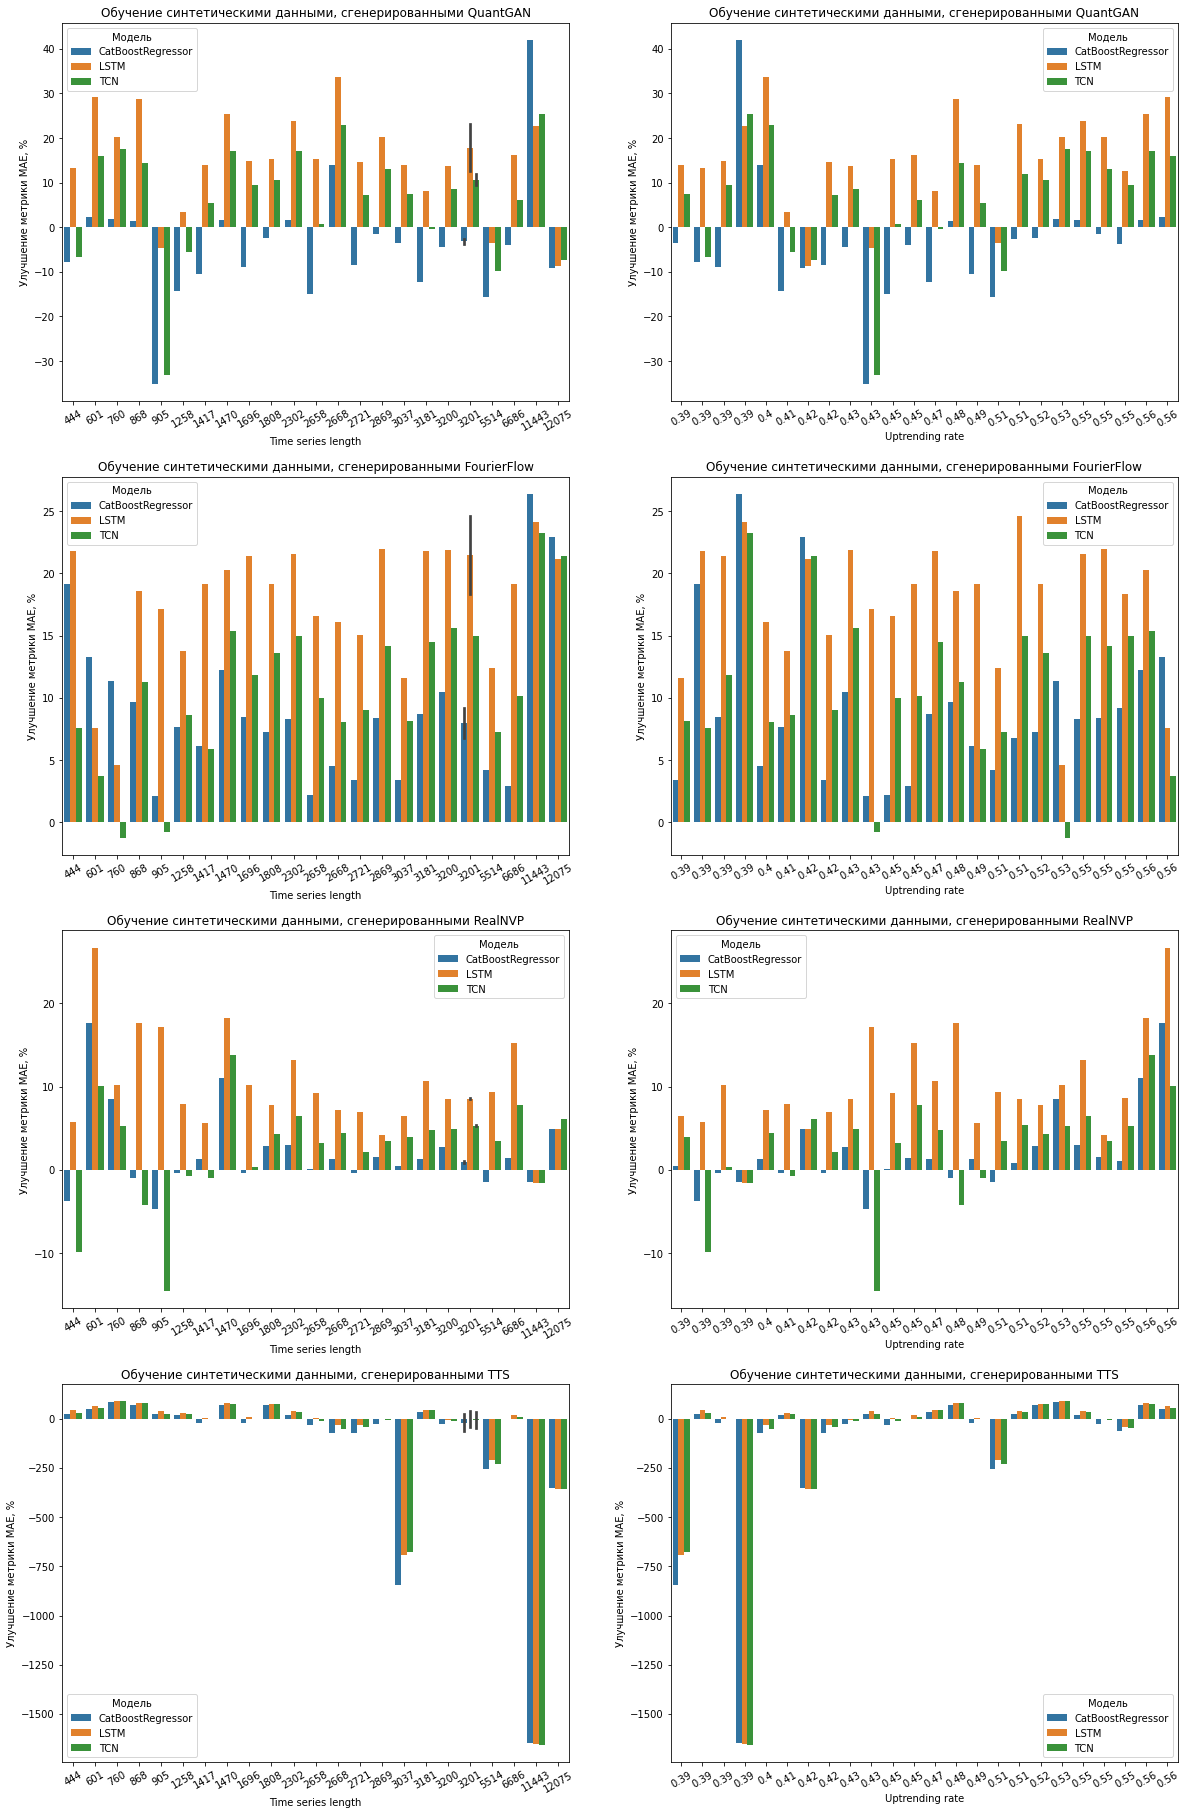

In [40]:
synth_models = ["QuantGAN", "FourierFlow", "RealNVP", "TTS"]
fig, axs = plt.subplots(len(synth_models), 2, figsize=(20, 8 * len(synth_models)))
gains = gains.rename(columns={"model": "Модель"})

for i in range(len(synth_models)):
    sns.barplot(data=gains, x="length", y=f"test_{synth_models[i]}", hue="Модель", ax=axs[i][0])
    axs[i][0].set_xlabel("Time series length")
    axs[i][0].set_xticklabels(sorted(gains["length"].unique()), rotation=30)
    axs[i][0].set_ylabel("Улучшение метрики MAE, %")

    sns.barplot(data=gains, x="uptrending_rate", y=f"test_{synth_models[i]}", hue="Модель", ax=axs[i][1])
    axs[i][1].set_xlabel("Uptrending rate")
    axs[i][1].set_xticklabels(map(lambda x: round(x, 2), sorted(gains.uptrending_rate.unique())), rotation=30)
    axs[i][1].set_ylabel("Улучшение метрики MAE, %")

    for j in range(2): axs[i][j].set_title(f"Обучение синтетическими данными, сгенерированными {synth_models[i]}")

gains = gains.rename(columns={"Модель": "model"})
plt.show()

In [13]:
length_intervals = [0, 1000, 5000, 13000]
temp = []
for i in range(1, len(length_intervals)):
    temp.append(gains[((gains.length > length_intervals[i - 1]) & (gains.length < length_intervals[i]))]\
        .groupby("model").mean())
    temp[- 1]["length"] = f"{length_intervals[i - 1]}-{length_intervals[i]}"
pd.concat(temp).drop(columns=["uptrending_rate", "ts_id"])

,train_QuantGAN,test_QuantGAN,train_FourierFlow,test_FourierFlow,train_RealNVP,test_RealNVP,train_TTS,test_TTS,length
model,,,,,,,,,
CatBoostRegressor,-23.079937,-7.441804,6.152635,11.101718,12.006110,3.367282,48.889308,51.474961,0-1000
LSTM,-319.720051,17.404497,-64.589099,13.919296,20.863652,15.533221,-75.463412,62.905488,0-1000
TCN,-141.645753,1.626106,-4.007949,4.101287,36.882509,-2.665364,3.381399,55.050960,0-1000
CatBoostRegressor,-10.922674,-4.679374,6.892583,7.141354,4.858513,1.753080,-48.881244,-62.907336,1000-5000
LSTM,-324.680329,16.812224,-166.225075,18.866459,-23.635664,8.898185,-368.399804,-31.516895,1000-5000
TCN,-100.717439,9.033425,-27.893156,11.980901,-0.356643,4.053301,-144.896162,-38.106536,1000-5000
CatBoostRegressor,1.003306,3.313148,14.477927,14.096863,2.468375,0.841363,-574.029785,-562.959161,5000-13000
LSTM,-96.232545,6.655528,-57.597908,19.210990,-58.446408,7.012361,-720.333332,-549.630240,5000-13000
TCN,-35.817310,3.580245,-9.879439,15.522977,-16.059971,3.962441,-673.830153,-558.800475,5000-13000


c:\Users\Владислав\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Владислав\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1558 samples in 0.001s...
[t-SNE] Computed neighbors for 1558 samples in 0.349s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1558
[t-SNE] Computed conditional probabilities for sample 1558 / 1558
[t-SNE] Mean sigma: 0.196242
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.311028
[t-SNE] KL divergence after 300 iterations: 1.565883


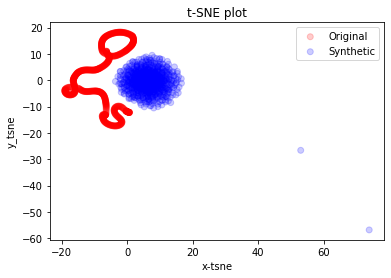

In [12]:
ind = 1
iterator = get_hsm_dataset(dataset_dir, selected_files=dataset_dir / "selected.csv")
for _ in range(ind): next(iterator)
train = next(iterator)
for model_name in ["QuantGAN", "FourierFlow", "RealNVP", "TTS_GAN_standard"]:
    synth = np.load(dataset_dir / "synthetic" / model_name / f"selected{ind}.npy")
    train_temp = np.array([train.Close[i: i + synth.shape[1]] for i in range(len(train) - synth.shape[1] + 1)])
    train_temp = train_temp.reshape(*train_temp.shape, 1)
    synth = synth.reshape(*synth.shape, 1)
    visualization(train_temp, synth, analysis="tsne")
    break

# Synthetic similarity results

In [7]:
synth_sim_results = {"model": ["QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN"], "kl_div": [], "sj_div": []}
for model in synth_sim_results["model"]:
    df = pd.read_csv(results_dir / f"synth_sim_{model}.csv")
    for col in df.columns:
        synth_sim_results[col].append(df[col].mean())
synth_sim_results = pd.DataFrame(synth_sim_results).rename(columns={"sj_div": "js_div"})
synth_sim_results

,model,kl_div,js_div
0,QuantGAN,0.069451,0.018835
1,RealNVP,0.006596,0.001754
2,FourierFlow,0.001913,0.000488
3,TTS_GAN,0.062544,0.016595


<AxesSubplot:xlabel='model', ylabel='kl_div'>

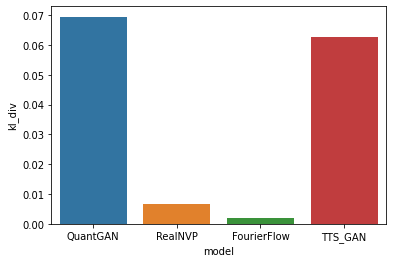

In [9]:
sns.barplot(data=synth_sim_results, x="model", y="kl_div")

<AxesSubplot:xlabel='model', ylabel='js_div'>

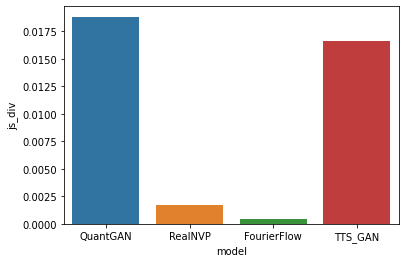

In [10]:
sns.barplot(data=synth_sim_results, x="model", y="js_div")

In [5]:
dfs = {}
for res_type in ("real", "QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN"):
    for model in ("cbr", "LSTM", "TCN"):
        dfs[f"{res_type}_{model}"] = pd.read_csv(results_dir / f"{'synth_' if res_type != 'real' else ''}{res_type}_{model}_h8.csv")["test"]
results = pd.DataFrame(dfs)
results

,real_cbr,real_LSTM,real_TCN,QuantGAN_cbr,QuantGAN_LSTM,QuantGAN_TCN,RealNVP_cbr,RealNVP_LSTM,RealNVP_TCN,FourierFlow_cbr,FourierFlow_LSTM,FourierFlow_TCN,TTS_GAN_cbr,TTS_GAN_LSTM,TTS_GAN_TCN
0,0.288982,0.337774,0.305525,0.693380,0.668358,0.694042,0.270364,0.263139,0.263170,0.427184,0.490068,0.481770,0.798384,0.806980,0.790379
1,0.780373,1.024646,1.033291,0.773823,0.771978,0.775109,0.701257,0.685425,0.694904,0.750206,0.783187,0.781763,0.793257,0.798198,0.790306
2,0.998907,1.228704,1.125204,0.716905,0.702170,0.704862,0.986167,0.995101,0.994633,0.966919,1.001375,0.979312,0.790619,0.782594,0.780294
3,0.641445,0.846785,0.698255,0.724907,0.719485,0.720792,0.655919,0.649208,0.645889,0.700888,0.718741,0.705893,0.879227,0.879064,0.878082
4,0.466460,0.567692,0.540812,0.698485,0.696218,0.688926,0.395946,0.416568,0.417269,0.554147,0.613872,0.591874,0.750634,0.742558,0.746301
5,0.551621,0.792534,0.668134,0.803035,0.787053,0.797309,0.532734,0.521385,0.524385,0.569858,0.613753,0.580503,0.832567,0.834658,0.832376
6,0.708106,0.835228,0.763743,0.680686,0.666202,0.667117,0.720033,0.717533,0.718349,0.734381,0.751157,0.751947,0.866350,0.867378,0.869062
7,0.507694,0.688740,0.629459,0.761997,0.748750,0.749202,0.502214,0.511527,0.513609,0.570269,0.588928,0.587876,0.832571,0.835007,0.835886
8,0.576141,0.799459,0.696266,0.776197,0.773419,0.772145,0.537032,0.555594,0.553356,0.606009,0.630148,0.627310,0.783423,0.783956,0.775838
9,1.041014,1.399449,1.337014,0.726646,0.746674,0.734894,1.019907,1.157368,1.161035,0.966879,1.075947,1.075313,0.823228,0.821692,0.822092


In [6]:
corrs = {}
for model in ("cbr", "LSTM", "TCN"):
    for res_type in ("QuantGAN", "RealNVP", "FourierFlow", "TTS_GAN"):
        corrs[f"{model}_{res_type}"] = np.corrcoef([results[f"real_{model}"], results[f"{res_type}_{model}"]])[0][1]
corrs

{'cbr_QuantGAN': -0.14237987829525234,
 'cbr_RealNVP': 0.9966447575833814,
 'cbr_FourierFlow': 0.9826264373520454,
 'cbr_TTS_GAN': 0.004087065391507676,
 'LSTM_QuantGAN': -0.034483599735833176,
 'LSTM_RealNVP': 0.976147904274337,
 'LSTM_FourierFlow': 0.960306884630552,
 'LSTM_TTS_GAN': 0.03405040267822271,
 'TCN_QuantGAN': -0.07246561136340017,
 'TCN_RealNVP': 0.9833993396770198,
 'TCN_FourierFlow': 0.9701446554666892,
 'TCN_TTS_GAN': -0.012045309763865107}